In [1]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

from sklearn.model_selection import train_test_split

from tqdm impport tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
root_dir = 'C:/Users/thffh/Documents/CNN/project/datasets/dogs'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [4]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=1)[1]] = i

In [5]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [6]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        self.annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [7]:
transformer = A.Compose([
    A.Resize(224,224),
    A.OneOf([
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
    ], p=1),
    A.Normalize(),
    ToTensorV2()
])

In [8]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [9]:
total_label = [data['label'] for data in total_dataset]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

In [10]:
train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [11]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

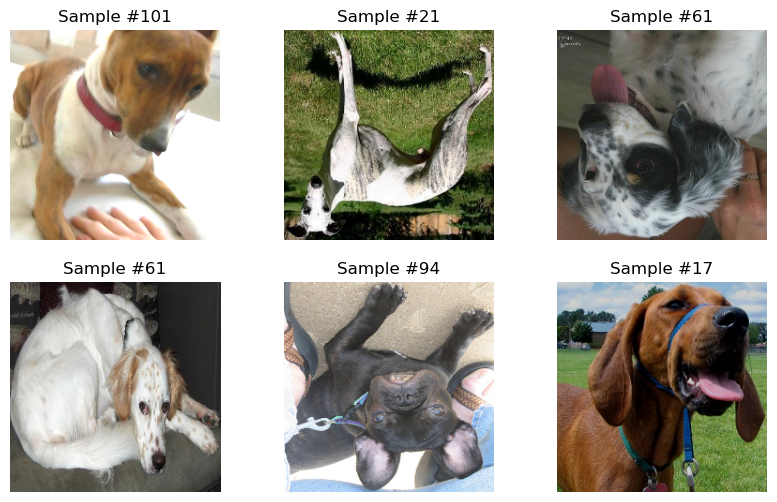

In [12]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [13]:
batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [14]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([16, 3, 224, 224]), 16)

# 모델 생성

In [15]:
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

## 모델 변경

In [16]:
model.fc = nn.Linear(in_features=1024, out_features=120, bias=True)

In [17]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [18]:
for parameter in model.fc.parameters():
    parameter.requires_grad=True

In [19]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [20]:
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [21]:
out = model(batch['image'].to(device))
out.shape

torch.Size([16, 120])

In [22]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [23]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# 모델 학습

In [24]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [25]:
writer = SummaryWriter()

In [26]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 10


    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in trainloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
                writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
                writer.add_scalars('Train Loss and Valid Loss',
                                    {'Train' : train_loss/len(trainloader),
                                    'Valid' : valid_loss/len(validloader)}, epoch+1)
                writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)

                if (valid_loss < min_loss) and (valid_accuracy >= max_accuracy):
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'D:/coding/models/dogs/best_ckpt_transfer_google_lr001.pth')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')
                        writer.flush()
                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)
                    
    writer.flush()

In [27]:
epochs = 150
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/150....... Train Loss : 2.715 Valid Loss : 1.677 Valid Accuracy : 0.561
save ckpt
Epoch : 2/150....... Train Loss : 1.726 Valid Loss : 1.435 Valid Accuracy : 0.606
save ckpt
Epoch : 3/150....... Train Loss : 1.544 Valid Loss : 1.428 Valid Accuracy : 0.601
Epoch : 4/150....... Train Loss : 1.442 Valid Loss : 1.322 Valid Accuracy : 0.627
save ckpt
Epoch : 5/150....... Train Loss : 1.387 Valid Loss : 1.334 Valid Accuracy : 0.631
----trigger---- 1
Epoch : 6/150....... Train Loss : 1.326 Valid Loss : 1.305 Valid Accuracy : 0.635
save ckpt
Epoch : 7/150....... Train Loss : 1.305 Valid Loss : 1.274 Valid Accuracy : 0.629
Epoch : 8/150....... Train Loss : 1.277 Valid Loss : 1.340 Valid Accuracy : 0.618
----trigger---- 1
Epoch : 9/150....... Train Loss : 1.267 Valid Loss : 1.320 Valid Accuracy : 0.615
----trigger---- 2
Epoch : 10/150....... Train Loss : 1.237 Valid Loss : 1.268 Valid Accuracy : 0.642
save ckpt
Epoch : 11/150....... Train Loss : 1.225 Valid Loss : 1.353 Valid Accuracy 

# 모델 예측

In [28]:
test_iter = iter(testloader)

batch = next(test_iter)

images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(3, device='cuda:0')


In [29]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([False], device='cuda:0')


pred: tensor([6], device='cuda:0') labels: tensor(3, device='cuda:0')
torch.Size([224, 224, 3])


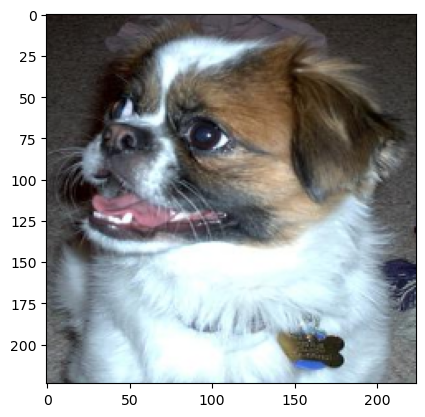

In [30]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [31]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in testloader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 1.174 Test Accuracy : 0.662


# 모델 저장

In [32]:
torch.save(model.state_dict(), 'D:/coding/models/dogs/last_ckpt_transfer_google_lr001.pth')

In [33]:
last_state_dict = torch.load('D:/coding/models/dogs/last_ckpt_transfer_google_lr001.pth')

In [39]:
last_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
last_model.fc = nn.Linear(in_features=1024, out_features=120)
last_model.to(device)
last_model.get_parameter = last_model.load_state_dict(last_state_dict)

In [40]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 1.151 Test Accuracy : 0.666


In [41]:
best_state_dict = torch.load('D:/coding/models/dogs/best_ckpt_transfer_google_lr001.pth')

In [44]:
best_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
best_model.fc = nn.Linear(in_features=1024, out_features=120)
best_model.to(device)
best_model.get_parameter = best_model.load_state_dict(best_state_dict)

In [45]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 1.107 Test Accuracy : 0.682
